In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

def robust_analyze_models(x, y, model_name, noise_level=0):
    """Улучшенный анализ ridge/lasso с исправленными проблемами"""
    
    # Разные диапазоны alpha для Ridge и Lasso
    if model_name == "Ridge":
        alphas = np.logspace(-4, 6, 200)  # Широкий диапазон для Ridge
    else:
        alphas = np.logspace(-2, 8, 200)  # Более высокие значения для Lasso
    
    # Создаем pipeline
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=11, include_bias=False)),
        ('scaler', StandardScaler())
    ])
    
    try:
        X_transformed = pipeline.fit_transform(x)
        
        # OLS baseline с обработкой вырожденности
        try:
            ols = LinearRegression()
            ols.fit(X_transformed, y)
            y_ols = ols.predict(X_transformed)
            r2_ols = r2_score(y, y_ols)
            rss_ols = np.sum((y - y_ols)**2)
            # Для OLS при p > n RSE не вычисляется корректно
            rse_ols = np.nan
        except:
            r2_ols = np.nan
            rss_ols = np.nan
            rse_ols = np.nan
            ols = None
        
        # CV для α с LOOCV (cv=5 для n=5)
        if model_name == "Ridge":
            model_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
        else:
            model_cv = LassoCV(alphas=alphas, cv=5, max_iter=50000, tol=1e-6, random_state=42, selection='cyclic')
        
        model_cv.fit(X_transformed, y)
        best_alpha = model_cv.alpha_
        
        # Метрики
        y_hat = model_cv.predict(X_transformed)
        r2 = r2_score(y, y_hat)
        rss = np.sum((y - y_hat)**2)
        
        # Для случаев когда p >= n, RSE не вычисляется корректно
        # Используем альтернативную формулу или оставляем N/A
        if len(y) > X_transformed.shape[1] + 1:
            rse = sqrt(rss / (len(y) - X_transformed.shape[1] - 1))
        else:
            rse = np.nan
        
        # Коэффициенты
        coefficients = model_cv.coef_
        non_zero = np.sum(np.abs(coefficients) > 1e-6)
        
        # VIF только если достаточно наблюдений и ненулевых коэффициентов
        mean_vif = np.nan
        if non_zero > 1 and X_transformed.shape[0] > non_zero + 1:
            try:
                active_idx = np.where(np.abs(coefficients) > 1e-6)[0]
                X_active = X_transformed[:, active_idx]
                vif_values = [variance_inflation_factor(X_active, i) for i in range(X_active.shape[1])]
                mean_vif = np.mean(vif_values)
            except:
                mean_vif = np.nan
        
        
        return {
            'model': model_cv,
            'alpha': best_alpha,
            'coefficients': coefficients,
            'non_zero': non_zero,
            'r2': r2,
            'rss': rss,
            'rse': rse,
            'vif': mean_vif,
            'pipeline': pipeline,
            'X_transformed': X_transformed
        }
        
    except Exception as e:
        print(f"Ошибка в {model_name}: {e}")
        return None

def plot_comprehensive_results(ridge_data, lasso_data, x, y, noise_level, ax1, ax2, ax3):
    """Комплексная визуализация результатов"""
    
    # График 1: Предсказания
    x_plot = np.linspace(-2.5, 2.5, 300).reshape(-1, 1)
    
    if ridge_data is not None:
        X_plot_ridge = ridge_data['pipeline'].transform(x_plot)
        y_plot_ridge = ridge_data['model'].predict(X_plot_ridge)
        ax1.plot(x_plot, y_plot_ridge, 'b-', linewidth=2, 
                label=f'Ridge (α={ridge_data["alpha"]:.2e})')
    
    if lasso_data is not None:
        X_plot_lasso = lasso_data['pipeline'].transform(x_plot)
        y_plot_lasso = lasso_data['model'].predict(X_plot_lasso)
        ax1.plot(x_plot, y_plot_lasso, 'r-', linewidth=2, 
                label=f'Lasso (α={lasso_data["alpha"]:.2e})')
    
    ax1.scatter(x, y, color='black', s=60, zorder=5, label='Данные')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'Предсказания моделей (шум σ={noise_level})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Коэффициенты Ridge
    if ridge_data is not None:
        ax2.stem(range(1, 12), ridge_data['coefficients'], 
                basefmt=" ", linefmt='b-', markerfmt='bo')
        ax2.set_title(f'Ridge коэффициенты\n(ненулевых: {ridge_data["non_zero"]}/11)')
    ax2.axhline(0, color='black', linewidth=0.5)
    ax2.set_xlabel('Степень полинома')
    ax2.set_ylabel('Коэффициент')
    ax2.grid(True, alpha=0.3)
    
    # График 3: Коэффициенты Lasso
    if lasso_data is not None:
        ax3.stem(range(1, 12), lasso_data['coefficients'], 
                basefmt=" ", linefmt='r-', markerfmt='ro')
        ax3.set_title(f'Lasso коэффициенты\n(ненулевых: {lasso_data["non_zero"]}/11)')
    ax3.axhline(0, color='black', linewidth=0.5)
    ax3.set_xlabel('Степень полинома')
    ax3.set_ylabel('Коэффициент')
    ax3.grid(True, alpha=0.3)

# Часть 1: Данные без шума
print("="*70)
print("ЧАСТЬ 1: АНАЛИЗ ДАННЫХ БЕЗ ШУМА")
print("="*70)

x_original = np.array([-2, -1, 0, 1, 2]).reshape(-1, 1)
y_original = np.array([-7, 0, 1, 2, 9])

print("Исходные данные:")
df_original = pd.DataFrame({'x': x_original.flatten(), 'y': y_original})
print(df_original)


ЧАСТЬ 1: АНАЛИЗ ДАННЫХ БЕЗ ШУМА
Исходные данные:
   x  y
0 -2 -7
1 -1  0
2  0  1
3  1  2
4  2  9



АНАЛИЗ ДЛЯ ДАННЫХ БЕЗ ШУМА


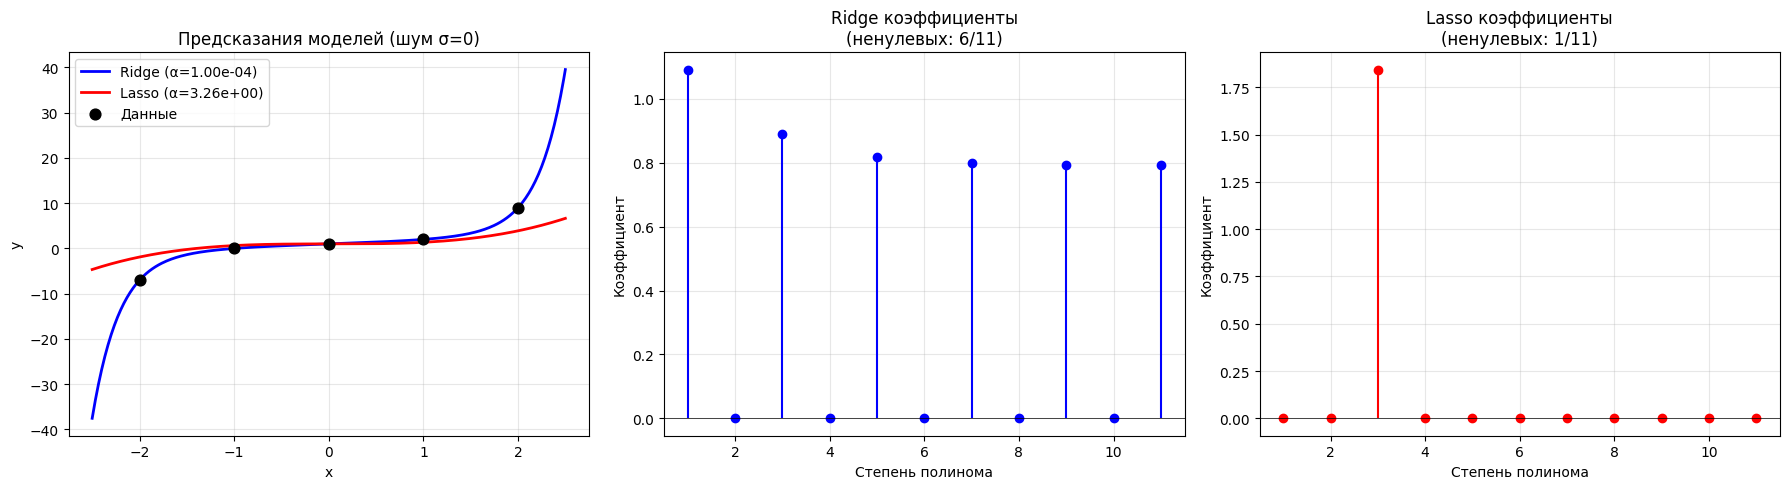

In [29]:
# Анализ без шума
print("\n" + "="*50)
print("АНАЛИЗ ДЛЯ ДАННЫХ БЕЗ ШУМА")
print("="*50)

ridge_no_noise = robust_analyze_models(x_original, y_original, "Ridge", 0)
lasso_no_noise = robust_analyze_models(x_original, y_original, "Lasso", 0)

# Визуализация без шума
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5))
plot_comprehensive_results(ridge_no_noise, lasso_no_noise, 
                          x_original.flatten(), y_original, 0, 
                          axes1[0], axes1[1], axes1[2])
plt.tight_layout()
plt.show()



ЧАСТЬ 2: АНАЛИЗ ДАННЫХ С ШУМОМ

АНАЛИЗ С ШУМОМ σ = 0.1
Зашумленные данные:
   x  y_noisy
0 -2   -6.950
1 -1   -0.014
2  0    1.065
3  1    2.152
4  2    8.977

АНАЛИЗ С ШУМОМ σ = 0.2
Зашумленные данные:
   x  y_noisy
0 -2   -6.901
1 -1   -0.028
2  0    1.130
3  1    2.305
4  2    8.953

АНАЛИЗ С ШУМОМ σ = 0.3
Зашумленные данные:
   x  y_noisy
0 -2   -6.851
1 -1   -0.041
2  0    1.194
3  1    2.457
4  2    8.930


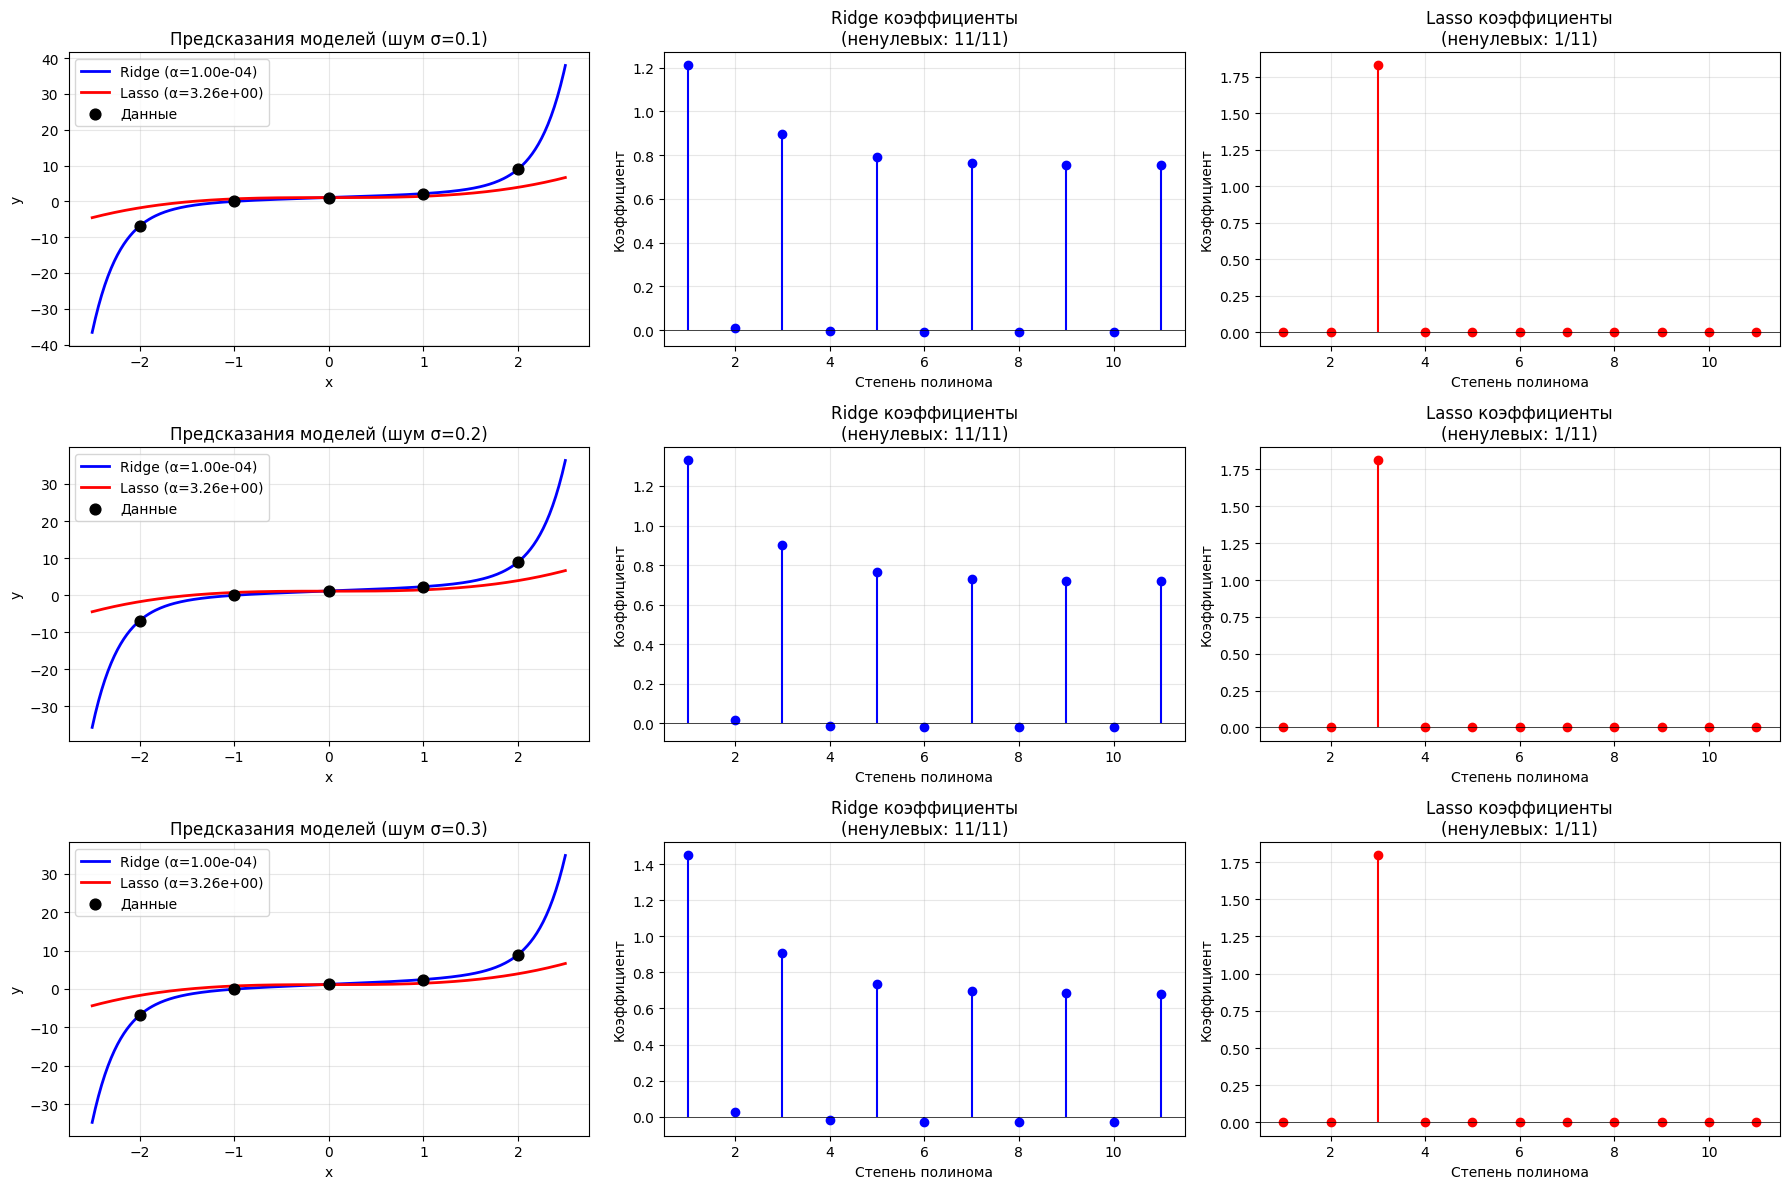

In [35]:
# Часть 2: Анализ с шумом
print("\n" + "="*70)
print("ЧАСТЬ 2: АНАЛИЗ ДАННЫХ С ШУМОМ")
print("="*70)

noise_levels = [0.1, 0.2, 0.3]
all_results = []

# Создаем общую фигуру для всех уровней шума
fig2, axes2 = plt.subplots(3, 3, figsize=(18, 12))

for i, sigma in enumerate(noise_levels):
    print(f"\n{'='*40}")
    print(f"АНАЛИЗ С ШУМОМ σ = {sigma}")
    print(f"{'='*40}")
    
    np.random.seed(42)
    y_noisy = y_original + np.random.normal(0, sigma, len(y_original))
    
    print("Зашумленные данные:")
    df_noisy = pd.DataFrame({'x': x_original.flatten(), 'y_noisy': y_noisy.round(3)})
    print(df_noisy)
    
    ridge_noise = robust_analyze_models(x_original, y_noisy, "Ridge", sigma)
    lasso_noise = robust_analyze_models(x_original, y_noisy, "Lasso", sigma)
    
    results = {
        'noise_std': sigma,
        'y_noisy': y_noisy,
        'ridge': ridge_noise,
        'lasso': lasso_noise
    }
    all_results.append(results)
    
    # Визуализация для этого уровня шума
    plot_comprehensive_results(ridge_noise, lasso_noise,
                             x_original.flatten(), y_noisy, sigma,
                             axes2[i, 0], axes2[i, 1], axes2[i, 2])

plt.tight_layout()
plt.show()


In [36]:
from sklearn.linear_model import Ridge, Lasso


def format_scientific(value, width=12):
    """Форматирование числа в научной нотации с фиксированной шириной"""
    if isinstance(value, str):
        return value.rjust(width)
    
    if abs(value) < 1e-20:
        return "0.000e+00".rjust(width)
    
    return f"{value: {width}.3e}"

def analyze_coefficients_for_alphas(x, y, alpha_values, model_type="Ridge"):
    """Анализ коэффициентов для разных значений α"""
    
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=11, include_bias=False)),
        ('scaler', StandardScaler())
    ])
    
    X_transformed = pipeline.fit_transform(x)
    coefficients_matrix = []
    
    for alpha in alpha_values:
        if model_type == "Ridge":
            model = Ridge(alpha=alpha, random_state=42)
        else:
            model = Lasso(alpha=alpha, max_iter=50000, random_state=42)
        
        model.fit(X_transformed, y)
        coefficients = model.coef_
        coefficients_matrix.append(coefficients)
    
    return np.array(coefficients_matrix)

def print_coefficient_table(coefficients_matrix, alpha_values, noise_level, model_type):
    """Вывод таблицы коэффициентов для заданного уровня шума"""
    
    print(f"\n{model_type.upper()} РЕГРЕССИЯ - ШУМ σ={noise_level}")
    print("=" * 80)
    
    # Заголовок таблицы
    header = "Степень | " + " | ".join([f"α={alpha:10.2e}" for alpha in alpha_values]) + " | Ненулевых"
    print(header)
    print("-" * len(header))
    
    for coef_idx in range(11):
        values = [coefficients_matrix[i, coef_idx] for i in range(len(alpha_values))]
        values_str = " | ".join([format_scientific(v) for v in values])
        
        # Подсчет ненулевых коэффициентов
        non_zero_count = np.sum([np.abs(v) > 1e-6 for v in values])
        non_zero_str = f"{non_zero_count}/{len(values)}"
        
        print(f"{coef_idx+1:7} | {values_str} | {non_zero_str:>9}")

# Основные данные
x_original = np.array([-2, -1, 0, 1, 2]).reshape(-1, 1)
y_original = np.array([-7, 0, 1, 2, 9])

# Уровни шума
noise_levels = [0, 0.1, 0.2, 0.3]

# Диапазоны α
ridge_alphas = [1e-6, 1e-4, 1e-2, 1e0, 1e1, 1e2, 1e4]
lasso_alphas = [1e-4, 1e-2, 1e0, 1e1, 1e2, 1e3, 1e4]

print("="*100)
print("АНАЛИЗ КОЭФФИЦИЕНТОВ ПРИ РАЗНЫХ ЗНАЧЕНИЯХ α И УРОВНЯХ ШУМА")
print("="*100)

# Анализ для каждого уровня шума
for noise_level in noise_levels:
    print(f"\n{'#'*50}")
    print(f"АНАЛИЗ ДЛЯ ШУМА σ = {noise_level}")
    print(f"{'#'*50}")
    
    # Генерация зашумленных данных
    if noise_level == 0:
        y_current = y_original
    else:
        np.random.seed(42)  # Для воспроизводимости
        y_current = y_original + np.random.normal(0, noise_level, len(y_original))
    
    # Ridge регрессия
    ridge_coefs = analyze_coefficients_for_alphas(x_original, y_current, ridge_alphas, "Ridge")
    print_coefficient_table(ridge_coefs, ridge_alphas, noise_level, "Ridge")
    
    # Lasso регрессия
    lasso_coefs = analyze_coefficients_for_alphas(x_original, y_current, lasso_alphas, "Lasso")
    print_coefficient_table(lasso_coefs, lasso_alphas, noise_level, "Lasso")


АНАЛИЗ КОЭФФИЦИЕНТОВ ПРИ РАЗНЫХ ЗНАЧЕНИЯХ α И УРОВНЯХ ШУМА

##################################################
АНАЛИЗ ДЛЯ ШУМА σ = 0
##################################################

RIDGE РЕГРЕССИЯ - ШУМ σ=0
Степень | α=  1.00e-06 | α=  1.00e-04 | α=  1.00e-02 | α=  1.00e+00 | α=  1.00e+01 | α=  1.00e+02 | α=  1.00e+04 | Ненулевых
----------------------------------------------------------------------------------------------------------------------------
      1 |    1.092e+00 |    1.092e+00 |    1.088e+00 |    9.113e-01 |    6.281e-01 |    1.866e-01 |    2.397e-03 |       7/7
      2 |   -2.220e-16 |   -6.661e-16 |   -4.996e-16 |   -5.551e-17 |    2.776e-17 |    1.388e-17 |    1.084e-19 |       0/7
      3 |    8.914e-01 |    8.914e-01 |    8.909e-01 |    8.520e-01 |    6.514e-01 |    1.974e-01 |    2.542e-03 |       7/7
      4 |    0.000e+00 |    5.551e-17 |    0.000e+00 |    0.000e+00 |    2.776e-17 |    1.388e-17 |    1.084e-19 |       0/7
      5 |    8.174e-01 |    8.174e-01 |